# 10. Final models on the merged cohort

1. **4-fold CV on the merged cohort**
    - HVPG16 threshold
    - compare 3P/3P+LSM/LSM logistic regression models
    - all models run on the same dataset = patient records containing all 4 required measurements
2. **4-fold CV on the updated VIENNA cohort**
    - HVPG16 threshold
    - compare 5P/3P/LSM logistic regression models
3. **Train final models on the merged cohort and extract coefficient sets**
    - 3P, 5P, 3P+LSM, 5P+LSM, LSM-only
    - both logistic regression (probabilities) and normal regression (predicted HVPG)
        - logistic regression: HVPG thresholds of 10 and 16
4. **Save predictions from all settings**
5. **Report prediction performance for different cohorts**
    - compare all settings
5. **Detailed look at specific etiologies**
    - only 3P and 3P-LSM settings
6. **HVPG16, 3P: likelihood ratios, etc.**

<sub>original notebook name: `VICIS_32_revision_v3_final_models_train.ipynb`</sub>

### Load merged cohort, keep only patients with 3P + LSM measurements present

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings

# prediction models
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, plot_roc_curve, roc_curve, confusion_matrix, ConfusionMatrixDisplay

# plotting configuration
from matplotlib import rc_params
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams['font.size'] = 16

from HVPG16_functions import *

In [2]:
preprocessed_data_path = "/Users/jreinis/OneDrive/Rotation/rotation/data_merged_final_v0/merged_datasets_preprocessed_final_v0.csv"
data_with_predictions_output_folder = "/Users/jreinis/OneDrive/Rotation/rotation/data_with_predictions_v4_revisions/"
output_folder_plots = "/Users/jreinis/OneDrive/Rotation/rotation/HVPG16_manuscript_figures_v4_revision/"

In [3]:
etiology_codes = {1:"ALD",
                  2:"VIRAL",
                  3:"ALD+VIRAL",
                  4:"NASH",
                  5:"CHOL",
                  6:"OTHER"}

In [4]:
datasets_order = ["VIENNA", "ANTWERP", "BARCELONA-HC", "BARCELONA-HSP", "FRANKFURT", "MADRID", "MODENA", "PARIS"]

# rename Barcelona dataset names for plotting purposes (HC/HSP on newline)
rename_barcelona = {"BARCELONA-HSP": "BARCELONA\n(HSP)", "BARCELONA-HC": "BARCELONA\n(HC)"}
# order of (renamed) datasets to show
datasets_order_show = ["VIENNA", "ANTWERP", "BARCELONA\n(HC)", "BARCELONA\n(HSP)", "FRANKFURT", "MADRID", "MODENA", "PARIS"]

In [5]:
data = pd.read_csv(preprocessed_data_path)
# call liver stiffness just LSM
data.rename(columns = {"VCTE-LSM-kPa":"LSM"}, inplace=True)
data["HVPG_label"] = "HVPG < 16"
data.loc[data.HVPG >= 16, 'HVPG_label'] = "HVPG ≥ 16"

### 1. HVPG16, merged cohort, 3P vs LSM: final 4-fold CV on the merged cohort (Fig. 4)
- 3P+LSM vs 3P vs LSM 

In [6]:
# remove patients with incomplete records for the required parameters
data_subset = data.copy()
for variable in ["HVPG"] + ["PLT", "BILI", "INR", "LSM"]:
    data_subset = data_subset[data_subset[variable].notnull()]
data_subset = data_subset.reset_index(drop=True)

# for formatting dataset names on the plots
data_subset["dataset_display"] = data_subset["dataset"].replace(rename_barcelona)

data_subset.shape[0]

796

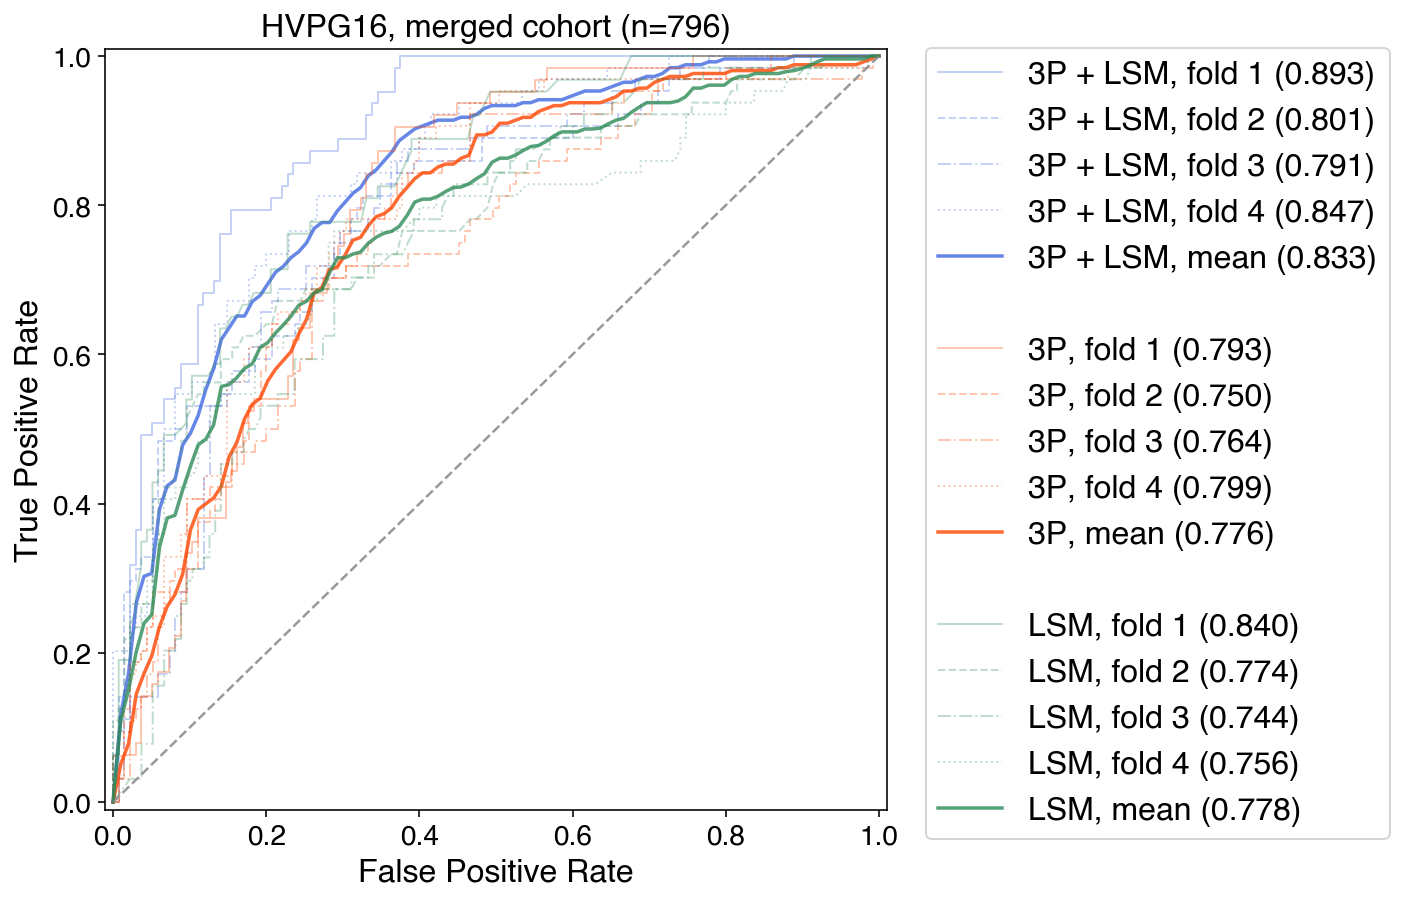

In [7]:
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
classifier = LogisticRegression(C=0.6, warm_start=False, max_iter=1000)

ax = plt.figure(figsize=(7,7))

X = data_subset[["PLT", "BILI", "INR", "LSM"]]
y = 1*(data_subset["HVPG"] >= 16)
plot_ROC_CV(classifier, cv, X, y, "royalblue", "3P + LSM")

# trick to have space in the legend
plt.plot([0, 1], [0, 1], linestyle='--', lw=1.25, color='white', label=' ', alpha=.8)

X = data_subset[["PLT", "BILI", "INR"]]
y = 1*(data_subset["HVPG"] >= 16)
plot_ROC_CV(classifier, cv, X, y, "orangered", "3P")

# trick to have space in the legend
plt.plot([0, 1], [0, 1], linestyle='--', lw=1.25, color='white', label=' ', alpha=.8)

X = data_subset[["LSM"]]
y = 1*(data_subset["HVPG"] >= 16)
plot_ROC_CV(classifier, cv, X, y, "seagreen", "LSM")

plt.plot([0, 1], [0, 1], linestyle='--', lw=1.25, color='grey', label='', alpha=.8)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=16)
plt.ylabel('True Positive Rate',fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1.001), loc=2, borderaxespad=0.,prop={"size":16})
plt.title(f"HVPG16, merged cohort (n={len(data_subset)})", fontsize=16)
plt.savefig(output_folder_plots + "merged_cohort_final_CV_comparison.pdf", bbox_inches="tight")
plt.show()

### 2. HVPG16, VIENNA cohort, 5P vs 3P vs LSM: 4-fold CV on the VIENNA cohort (Fig. 2)
- 5P vs 3P vs LSM

In [8]:
# remove patients with incomplete records for the required parameters
data_subset = data[data["dataset"] == "VIENNA"].copy()
for variable in ["HVPG"] + ["PLT", "BILI", "aPTT", "GGT", "CHE", "INR", "LSM"]:
    data_subset = data_subset[data_subset[variable].notnull()]
data_subset = data_subset.reset_index(drop=True)

# for formatting dataset names on the plots
data_subset["dataset_display"] = data_subset["dataset"].replace(rename_barcelona)

data_subset.shape[0]

151

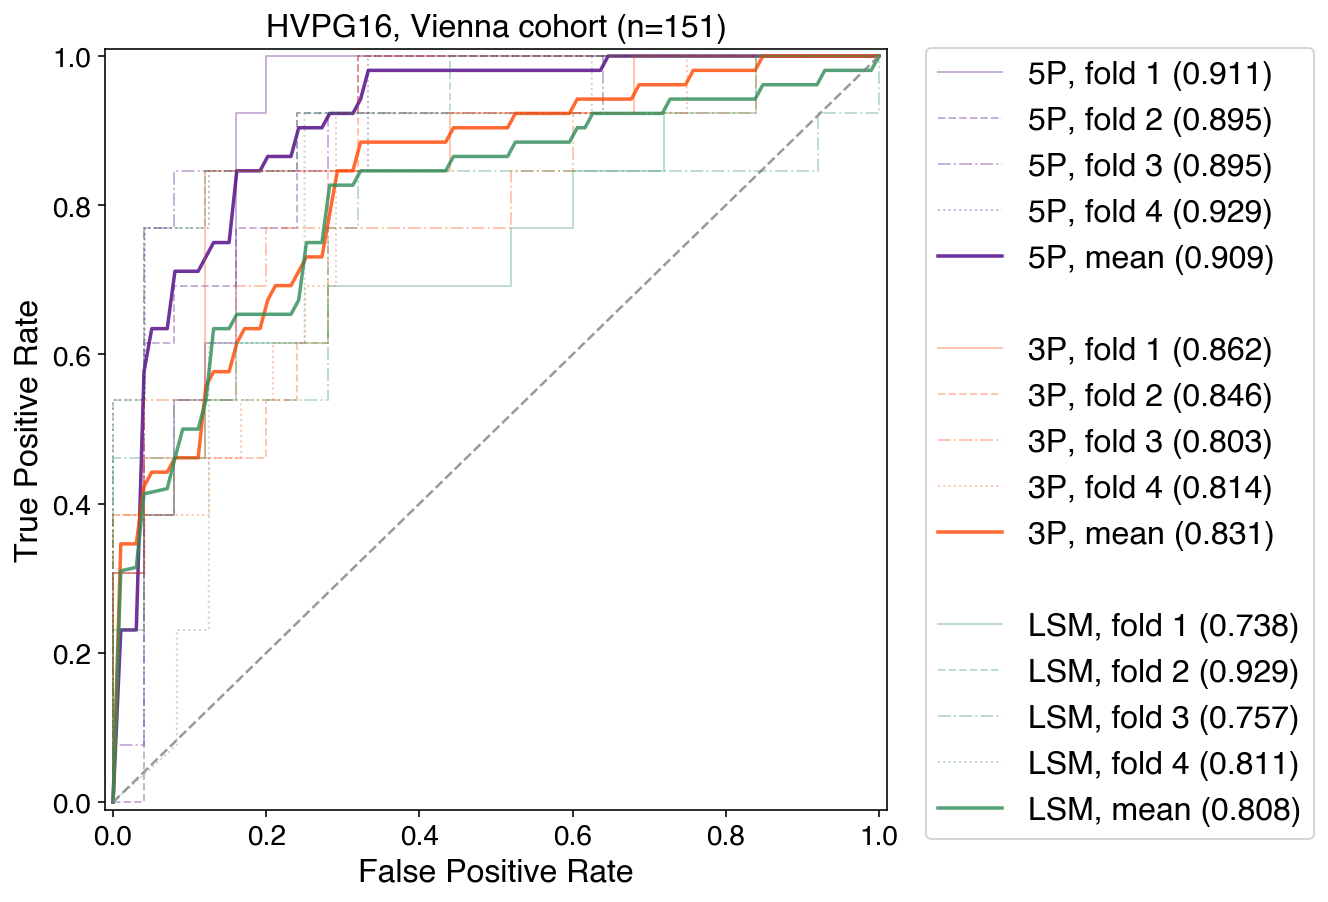

In [9]:
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)
classifier = LogisticRegression(C=0.6, warm_start=False, max_iter=1000)

ax = plt.figure(figsize=(7,7))

X = data_subset[["PLT", "BILI", "aPTT", "GGT", "CHE"]]
y = 1*(data_subset["HVPG"] >= 16)
plot_ROC_CV(classifier, cv, X, y, "indigo", "5P")

# trick to have space in the legend
plt.plot([0, 1], [0, 1], linestyle='--', lw=1.25, color='white', label=' ', alpha=.8)

X = data_subset[["PLT", "BILI", "INR"]]
y = 1*(data_subset["HVPG"] >= 16)
plot_ROC_CV(classifier, cv, X, y, "orangered", "3P")

# trick to have space in the legend
plt.plot([0, 1], [0, 1], linestyle='--', lw=1.25, color='white', label=' ', alpha=.8)

X = data_subset[["LSM"]]
y = 1*(data_subset["HVPG"] >= 16)
plot_ROC_CV(classifier, cv, X, y, "seagreen", "LSM")

plt.plot([0, 1], [0, 1], linestyle='--', lw=1.25, color='grey', label='', alpha=.8)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=16)
plt.ylabel('True Positive Rate',fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1.001), loc=2, borderaxespad=0.,prop={"size":16})
plt.title(f"HVPG16, Vienna cohort (n={len(data_subset)})", fontsize=16)
plt.savefig(output_folder_plots + "VIENNA_cohort_final_CV_comparison.pdf", bbox_inches="tight")
plt.show()

### 3. Train final models on merged cohort
- both HVPG16 and HVPG10 thresholds
- for each parameter set, train on the complete cohort of patients with records present
- train a logistic regression (classification) and lasso regression (regression) models

In [10]:
def plot_ROC_v2(clf, X, y, ax, color='r', model=""):
    ax.plot([0, 1], [0, 1], linestyle='--', lw=1.25, color='grey', label='', alpha=.8)
    
    # get points on ROC curve
    probas_ = clf.predict_proba(X)
    fpr, tpr, thresholds = roc_curve(y, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    # calculate optimal threshold (Youden's index)
    idx = np.argmax(tpr - fpr)
    
    # plot
    ax.plot(fpr, tpr, lw=1.5, alpha=0.8, color=color, label=f'{model} ({roc_auc:.3f})')
    ax.set_xlim([-0.01, 1.01])
    ax.set_ylim([-0.01, 1.01])
    ax.set_xlabel('False Positive Rate',fontsize=16)
    ax.set_ylabel('True Positive Rate',fontsize=16)
    ax.set_title(f"{model} (n={len(X)}, AUC={roc_auc:.3f})",fontsize=16)
    return roc_auc, thresholds[idx]

In [11]:
def plot_regression_v2(reg, X, y,  ax, model=""):
    y_pred = reg.predict(X)
    r2 = r2_score(y, y_pred)
    # scatterplot of y
    sns.scatterplot(x = y, y = y_pred, ax=ax)
    ax.axhline(16, ls = "--", color = "r", lw = .75) 
    ax.axvline(16, ls = "--", color = "r", lw = .75)
    ax.axhline(10, ls = "--", lw = .75) 
    ax.axvline(10, ls = "--", lw = .75)
    ax.axis('equal')
    ax.axline((5, 5), (6, 6), ls = "-", color = "black", lw = .75, alpha = .3)
    ax.set_xlabel('HVPG',fontsize=16)
    ax.set_ylabel('Predicted HVPG',fontsize=16)
    ax.set_title(f"{model} (n={len(X)}, $r^2$={r2:.3f})",fontsize=16)
    return r2

In [12]:
def train_final_model_v2(data, parameters, name):
    df = data[["HVPG"] + parameters].dropna(axis=0)
    
    # prepare data for training
    X = df[parameters]
    y_clf = 1*(df["HVPG"]>=16)
    y_clf_HVPG10 = 1*(df["HVPG"]>=10)
    y_reg = df["HVPG"]

    # train models
    lr = LogisticRegression(C = 1, max_iter=15000).fit(X, y_clf)
    lr_HVPG10 = LogisticRegression(C = 1, max_iter=15000).fit(X, y_clf_HVPG10)
    reg = Ridge(alpha=50).fit(X, y_reg)
    
    # plot ROC curve and regression evaluation thingy
    f, (ax1, ax2, ax3) = plt.subplots(1, 3,  figsize=(16,5))
    auc, best_threshold = plot_ROC_v2(lr, X, y_clf, ax1, model="HVPG16, " + name)
    auc_HVPG10, best_threshold_HVPG10 = plot_ROC_v2(lr_HVPG10, X, y_clf_HVPG10, ax2, model="HVPG10, " + name)
    r2 = plot_regression_v2(reg, X, y_reg, ax3, model=name)
    plt.show()
    
    coef = f'intercept={lr.intercept_[0]:.6f}, {", ".join([f"{par}={weight:.6f}" for par,weight in list(zip(parameters,lr.coef_[0]))])}'
    coef_HVPG10 = f'intercept={lr_HVPG10.intercept_[0]:.6f}, {", ".join([f"{par}={weight:.6f}" for par,weight in list(zip(parameters,lr_HVPG10.coef_[0]))])}'
    coef_reg = f'intercept={reg.intercept_:.6f}, {", ".join([f"{par}={weight:.6f}" for par,weight in list(zip(parameters,reg.coef_))])}'
    
    # general info
    print(f'[{", ".join(parameters)}]: {df.shape[0]} patients\n')
    
    # metrics and coefficients - classification
    print(f"HVPG16 AUROC (train and validate on same data): {roc_auc_score(y_clf, lr.predict_proba(X)[:, 1]):.3f}")
    print(f'Logistic regression coefficients: {coef}')
    print(f"Optimal threshold: {best_threshold:.3f}\n")

    # metrics and coefficients - classification
    print(f"HVPG10 AUROC (train and validate on same data): {roc_auc_score(y_clf_HVPG10, lr_HVPG10.predict_proba(X)[:, 1]):.3f}")
    print(f'Logistic regression coefficients: {coef_HVPG10}')
    print(f"Optimal threshold: {best_threshold_HVPG10:.3f}\n")

    # metrics and coefficients - classification
    print(f"r2 score (train and validate on same data): {r2_score(y_reg, reg.predict(X)):.3f}")
    print(f'Regression coefficients: {coef_reg}')
    
    return lr, auc, best_threshold, coef, lr_HVPG10, auc_HVPG10, best_threshold_HVPG10, coef_HVPG10, reg, r2,coef_reg

In [13]:
def evaluate_parameter_set(data, variables, settings, lrs, aucs, best_thresholds, coeffs, lrs_HVPG10, aucs_HVPG10, best_thresholds_HVPG10, coeffs_HVPG10, regs, r2s, coeffs_reg):
    _ = train_final_model_v2(data, variables, settings)
    lrs.append(_[0])
    aucs.append(_[1])
    best_thresholds.append(_[2])
    coeffs.append(_[3])
    lrs_HVPG10.append(_[4])
    aucs_HVPG10.append(_[5])
    best_thresholds_HVPG10.append(_[6])
    coeffs_HVPG10.append(_[7])
    regs.append(_[8])
    r2s.append(_[9])
    coeffs_reg.append(_[10])    

In [14]:
settings = ['3P', '5P', '3P+LSM', '5P+LSM', 'LSM-only']
variables = [['PLT', 'BILI', 'INR'],
             ['PLT', 'BILI', 'aPTT', 'CHE', 'GGT'],
             ['PLT', 'BILI', 'INR', 'LSM'],
             ['PLT', 'BILI', 'aPTT', 'CHE', "GGT", 'LSM'],
             ['LSM']]

In [15]:
n_patients = [data[["HVPG"] + pars].dropna(axis=0).shape[0] for pars in variables]
lrs, aucs, best_thresholds, coeffs, lrs_HVPG10, aucs_HVPG10, best_thresholds_HVPG10, coeffs_HVPG10, regs, r2s, coeffs_reg  = [],[],[],[],[],[],[],[],[],[],[]

#### 3-parameter

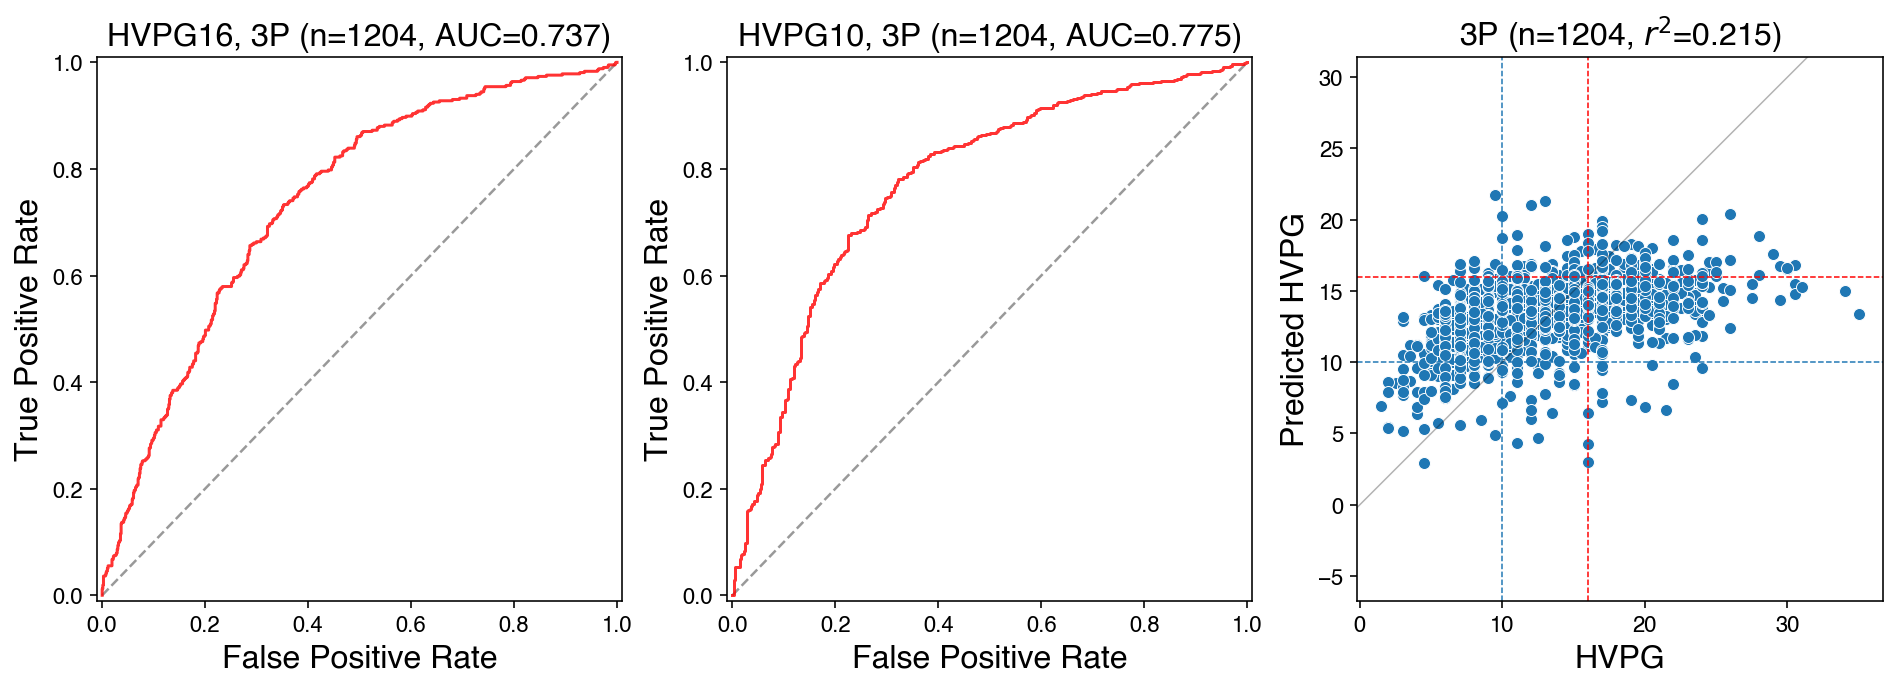

[PLT, BILI, INR]: 1204 patients

HVPG16 AUROC (train and validate on same data): 0.737
Logistic regression coefficients: intercept=-2.015195, PLT=-0.010163, BILI=0.116590, INR=1.946251
Optimal threshold: 0.332

HVPG10 AUROC (train and validate on same data): 0.775
Logistic regression coefficients: intercept=-1.368246, PLT=-0.009306, BILI=0.378559, INR=2.556866
Optimal threshold: 0.663

r2 score (train and validate on same data): 0.215
Regression coefficients: intercept=13.060925, PLT=-0.030378, BILI=0.667001, INR=2.627117


In [16]:
i = 0
evaluate_parameter_set(data, variables[i], settings[i], lrs, aucs, best_thresholds, coeffs, lrs_HVPG10, aucs_HVPG10, best_thresholds_HVPG10, coeffs_HVPG10, regs, r2s, coeffs_reg)

#### 5-parameter

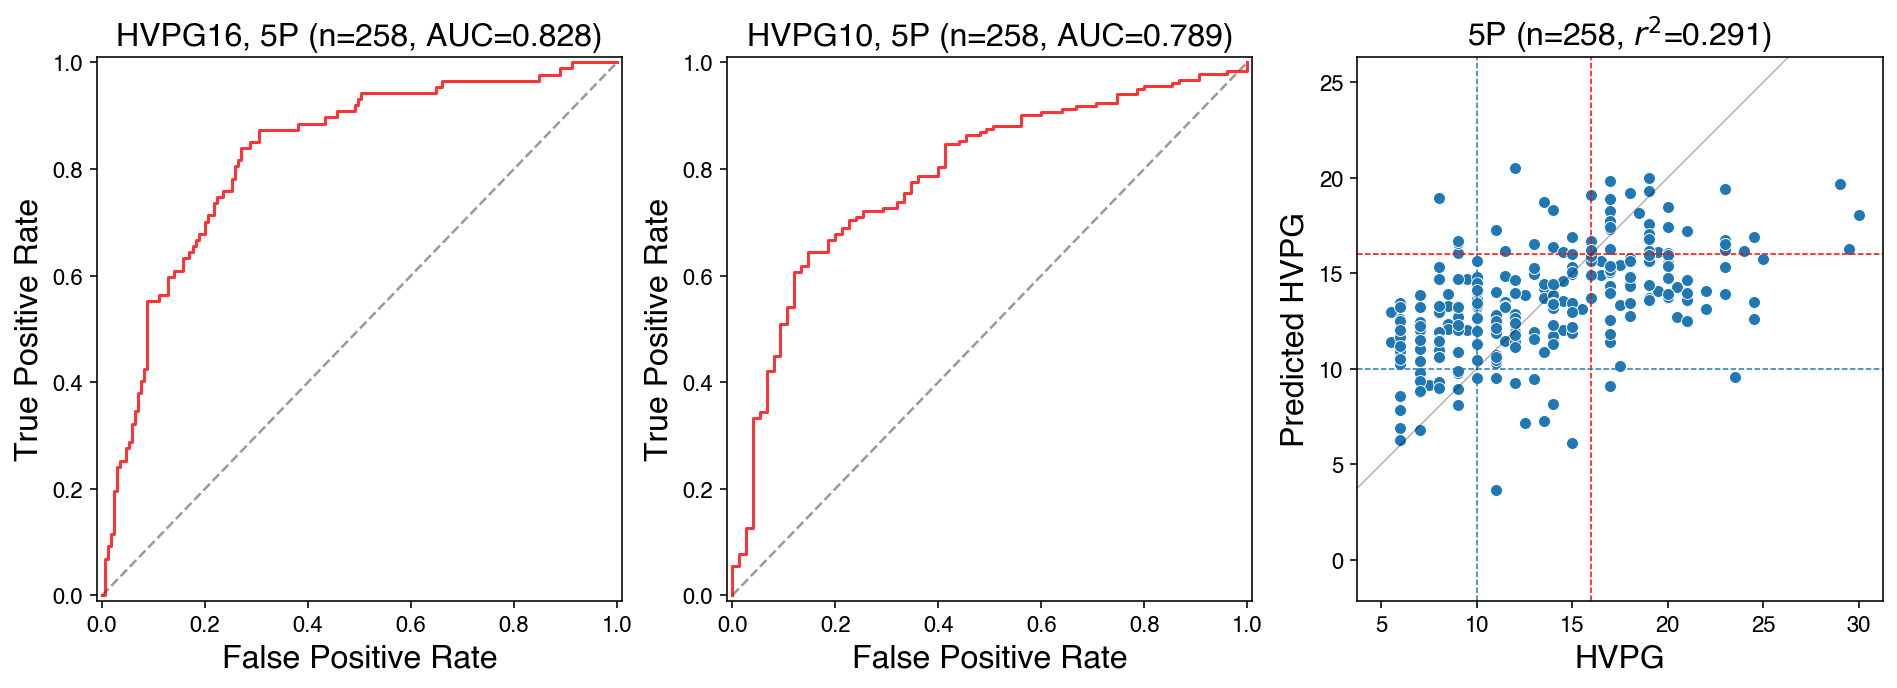

[PLT, BILI, aPTT, CHE, GGT]: 258 patients

HVPG16 AUROC (train and validate on same data): 0.828
Logistic regression coefficients: intercept=-2.487282, PLT=-0.017207, BILI=0.089392, aPTT=0.115019, CHE=-0.262005, GGT=0.003169
Optimal threshold: 0.293

HVPG10 AUROC (train and validate on same data): 0.789
Logistic regression coefficients: intercept=1.639494, PLT=-0.010951, BILI=-0.079770, aPTT=0.053278, CHE=-0.316437, GGT=0.003769
Optimal threshold: 0.752

r2 score (train and validate on same data): 0.291
Regression coefficients: intercept=9.850161, PLT=-0.030089, BILI=0.168214, aPTT=0.223738, CHE=-0.477526, GGT=0.006480


In [17]:
i = 1
evaluate_parameter_set(data, variables[i], settings[i], lrs, aucs, best_thresholds, coeffs, lrs_HVPG10, aucs_HVPG10, best_thresholds_HVPG10, coeffs_HVPG10, regs, r2s, coeffs_reg)

#### 3-parameter including liver stiffness

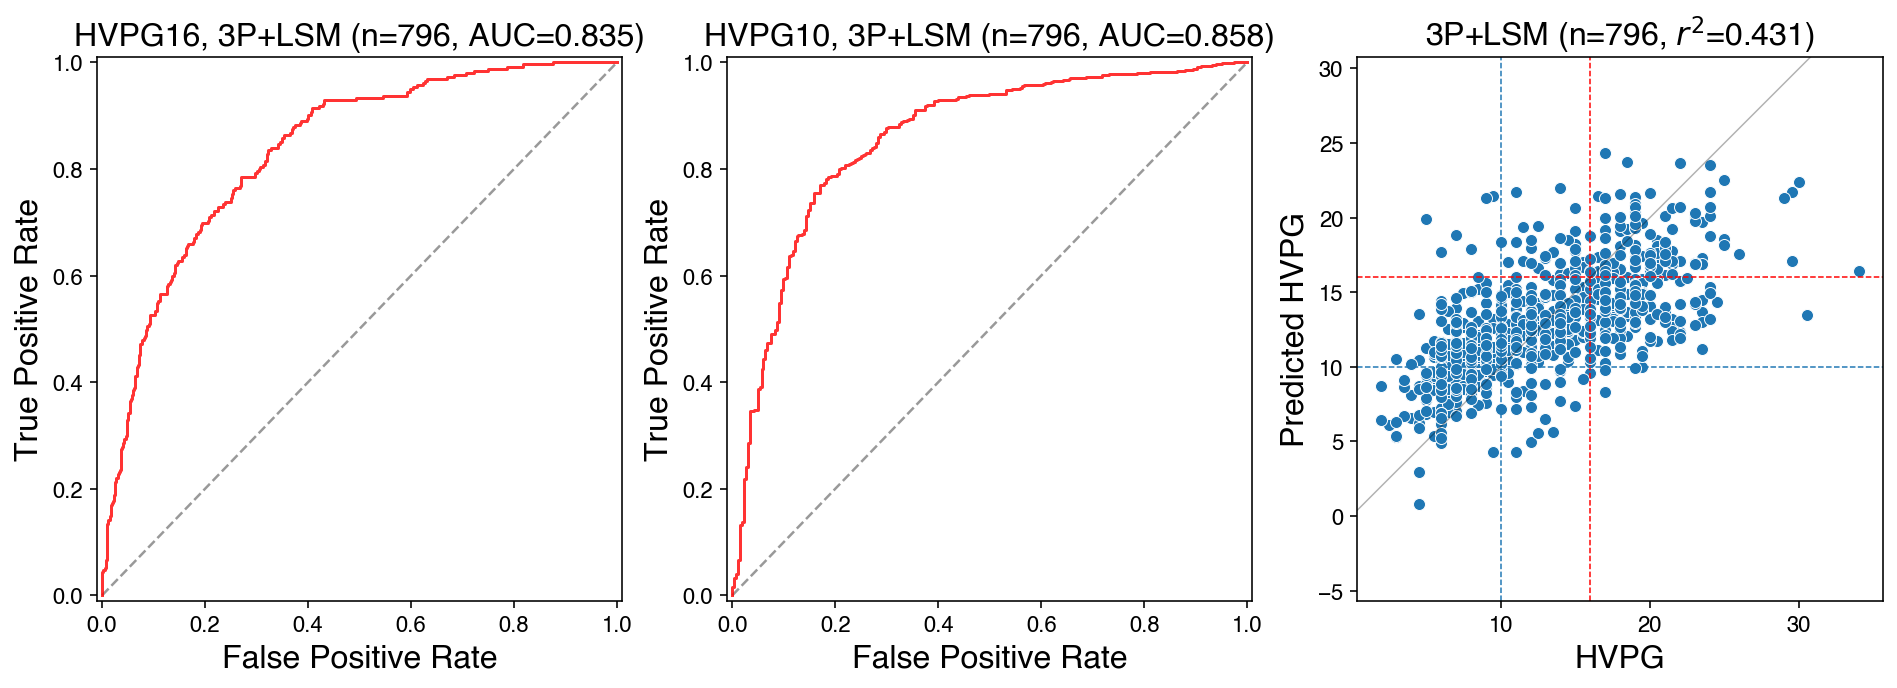

[PLT, BILI, INR, LSM]: 796 patients

HVPG16 AUROC (train and validate on same data): 0.835
Logistic regression coefficients: intercept=-2.168549, PLT=-0.015050, BILI=0.227967, INR=1.032043, LSM=0.056162
Optimal threshold: 0.292

HVPG10 AUROC (train and validate on same data): 0.858
Logistic regression coefficients: intercept=-1.552564, PLT=-0.012479, BILI=0.484583, INR=1.347533, LSM=0.081547
Optimal threshold: 0.648

r2 score (train and validate on same data): 0.431
Regression coefficients: intercept=10.894861, PLT=-0.029723, BILI=0.685411, INR=0.923888, LSM=0.143300


In [18]:
i = 2
evaluate_parameter_set(data, variables[i], settings[i], lrs, aucs, best_thresholds, coeffs, lrs_HVPG10, aucs_HVPG10, best_thresholds_HVPG10, coeffs_HVPG10, regs, r2s, coeffs_reg)

#### 5-parameter including liver stiffness

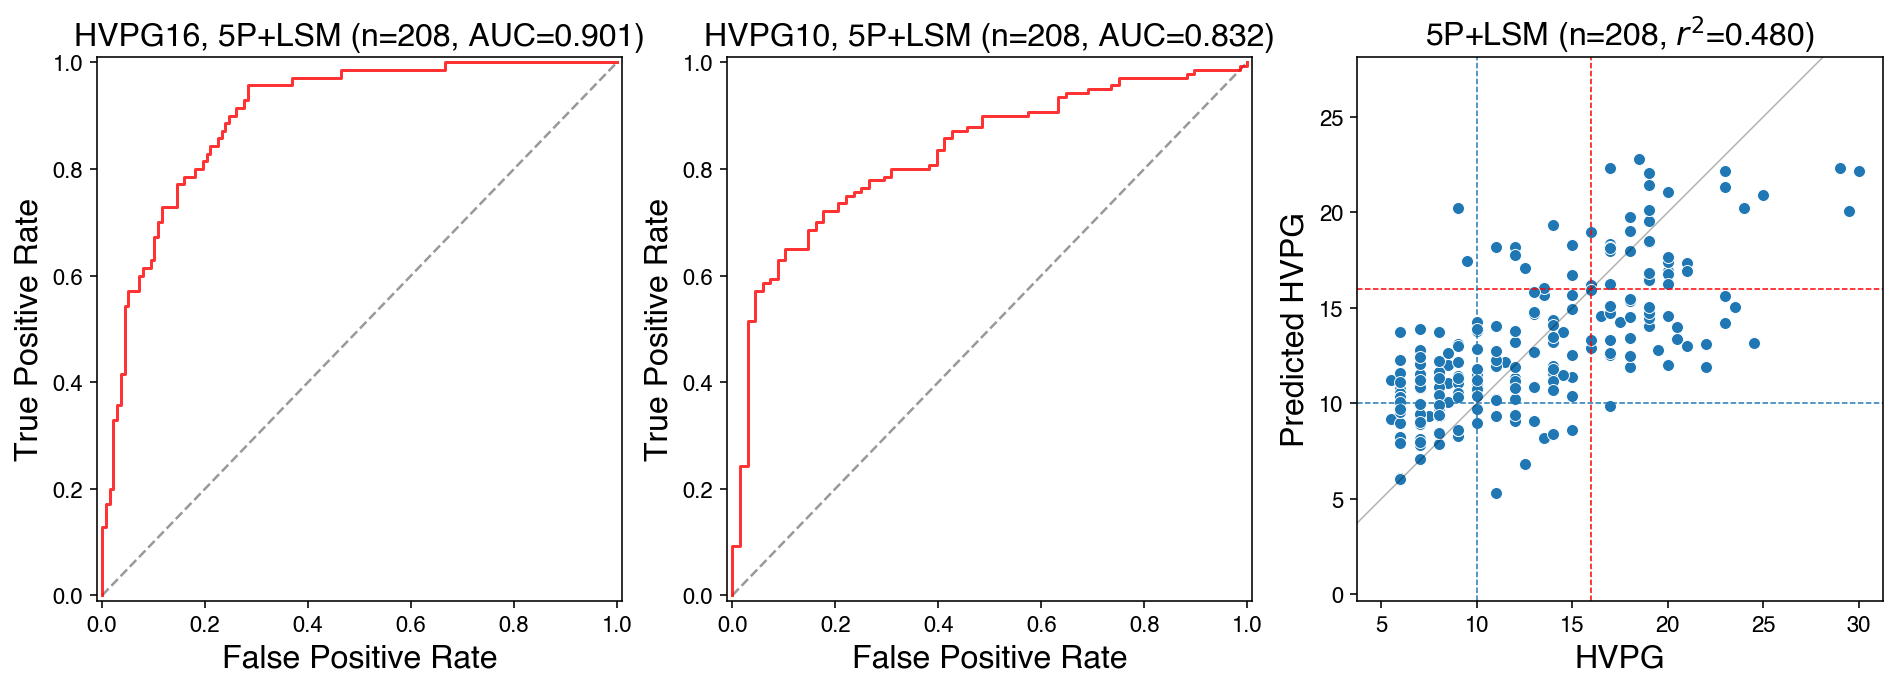

[PLT, BILI, aPTT, CHE, GGT, LSM]: 208 patients

HVPG16 AUROC (train and validate on same data): 0.901
Logistic regression coefficients: intercept=-4.537634, PLT=-0.018488, BILI=0.189922, aPTT=0.146026, CHE=-0.320170, GGT=0.001917, LSM=0.046499
Optimal threshold: 0.177

HVPG10 AUROC (train and validate on same data): 0.832
Logistic regression coefficients: intercept=-0.803739, PLT=-0.007348, BILI=-0.007613, aPTT=0.068443, CHE=-0.315671, GGT=0.002601, LSM=0.057918
Optimal threshold: 0.740

r2 score (train and validate on same data): 0.480
Regression coefficients: intercept=6.455701, PLT=-0.020336, BILI=0.127564, aPTT=0.199477, CHE=-0.446403, GGT=0.002931, LSM=0.119041


In [19]:
i = 3
evaluate_parameter_set(data, variables[i], settings[i], lrs, aucs, best_thresholds, coeffs, lrs_HVPG10, aucs_HVPG10, best_thresholds_HVPG10, coeffs_HVPG10, regs, r2s, coeffs_reg)

#### Only liver stiffness

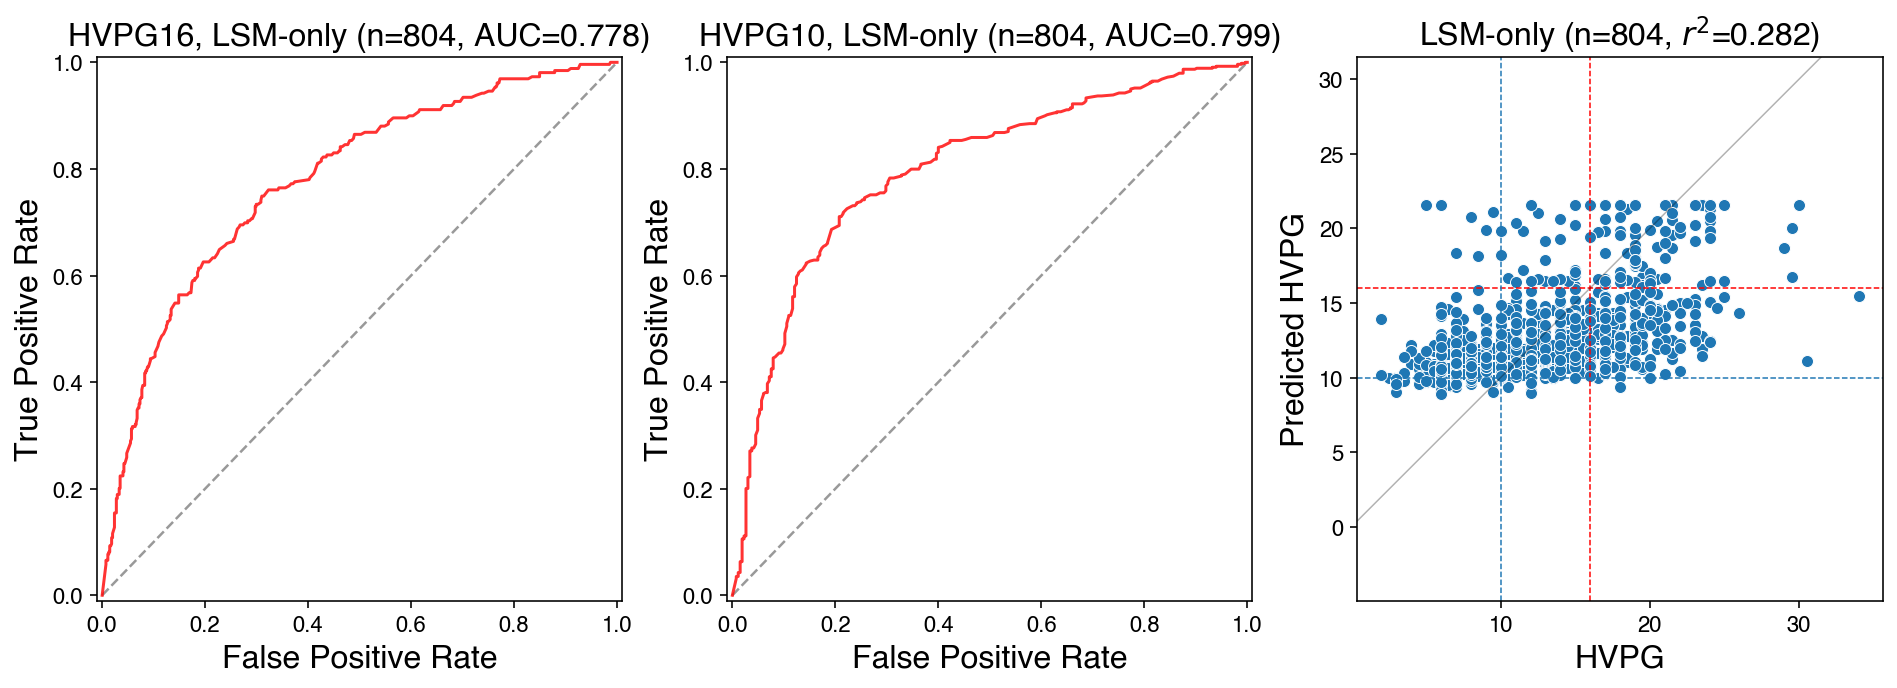

[LSM]: 804 patients

HVPG16 AUROC (train and validate on same data): 0.778
Logistic regression coefficients: intercept=-2.528566, LSM=0.064167
Optimal threshold: 0.260

HVPG10 AUROC (train and validate on same data): 0.799
Logistic regression coefficients: intercept=-1.456879, LSM=0.097177
Optimal threshold: 0.640

r2 score (train and validate on same data): 0.282
Regression coefficients: intercept=8.236355, LSM=0.177287


In [20]:
i = 4
evaluate_parameter_set(data, variables[i], settings[i], lrs, aucs, best_thresholds, coeffs, lrs_HVPG10, aucs_HVPG10, best_thresholds_HVPG10, coeffs_HVPG10, regs, r2s, coeffs_reg)

#### Report final metrics for each parameter set (on train cohort)

In [21]:
pd.DataFrame({"setting":settings,"parameters":variables,"patients":n_patients,
              "AUC_HVPG16":aucs,"AUC_HVPG10":aucs_HVPG10,"r2 score":r2s,
              "Youden_HVPG16": best_thresholds, "Youden_HVPG10":best_thresholds_HVPG10
             })

,setting,parameters,patients,AUC_HVPG16,AUC_HVPG10,r2 score,Youden_HVPG16,Youden_HVPG10
0,3P,"[PLT, BILI, INR]",1204,0.737397,0.774895,0.214746,0.332467,0.663008
1,5P,"[PLT, BILI, aPTT, CHE, GGT]",258,0.828258,0.788561,0.290770,0.292604,0.752413
2,3P+LSM,"[PLT, BILI, INR, LSM]",796,0.835004,0.858345,0.430560,0.292439,0.647888
3,5P+LSM,"[PLT, BILI, aPTT, CHE, GGT, LSM]",208,0.900828,0.832143,0.480091,0.177254,0.739586
4,LSM-only,[LSM],804,0.778467,0.798551,0.281812,0.259935,0.639715


#### Report final coefficients

##### HVPG16

In [22]:
for i, setting in enumerate(settings):
    print(f'{setting:10s}{coeffs[i]}')

3P        intercept=-2.015195, PLT=-0.010163, BILI=0.116590, INR=1.946251
5P        intercept=-2.487282, PLT=-0.017207, BILI=0.089392, aPTT=0.115019, CHE=-0.262005, GGT=0.003169
3P+LSM    intercept=-2.168549, PLT=-0.015050, BILI=0.227967, INR=1.032043, LSM=0.056162
5P+LSM    intercept=-4.537634, PLT=-0.018488, BILI=0.189922, aPTT=0.146026, CHE=-0.320170, GGT=0.001917, LSM=0.046499
LSM-only  intercept=-2.528566, LSM=0.064167


##### HVPG10

In [23]:
for i, setting in enumerate(settings):
    print(f'{setting:10s}{coeffs_HVPG10[i]}')

3P        intercept=-1.368246, PLT=-0.009306, BILI=0.378559, INR=2.556866
5P        intercept=1.639494, PLT=-0.010951, BILI=-0.079770, aPTT=0.053278, CHE=-0.316437, GGT=0.003769
3P+LSM    intercept=-1.552564, PLT=-0.012479, BILI=0.484583, INR=1.347533, LSM=0.081547
5P+LSM    intercept=-0.803739, PLT=-0.007348, BILI=-0.007613, aPTT=0.068443, CHE=-0.315671, GGT=0.002601, LSM=0.057918
LSM-only  intercept=-1.456879, LSM=0.097177


##### Regression

In [24]:
for i, setting in enumerate(settings):
    print(f'{setting:10s}{coeffs_reg[i]}')

3P        intercept=13.060925, PLT=-0.030378, BILI=0.667001, INR=2.627117
5P        intercept=9.850161, PLT=-0.030089, BILI=0.168214, aPTT=0.223738, CHE=-0.477526, GGT=0.006480
3P+LSM    intercept=10.894861, PLT=-0.029723, BILI=0.685411, INR=0.923888, LSM=0.143300
5P+LSM    intercept=6.455701, PLT=-0.020336, BILI=0.127564, aPTT=0.199477, CHE=-0.446403, GGT=0.002931, LSM=0.119041
LSM-only  intercept=8.236355, LSM=0.177287


### 4. Save predictions (if available) for each model and add to original table - all parameter sets

In [25]:
def report_final_predictions_v2(data, parameters, name, lr_16, lr_10, reg):
    # get subset of the data with the parameters available
    X = data[parameters].dropna(axis=0)
    result = pd.DataFrame(X).copy()
    # models = first is HVPG16, second is HVPG10, third is regression
    result[name+"_HVPG16_prob"] = lr_16.predict_proba(X)[:, 1]
    result[name+"_HVPG10_prob"] = lr_10.predict_proba(X)[:, 1]
    result[name+"_HVPG_pred"] = reg.predict(X)
    return result.copy()

In [26]:
# add predictions of each model for the patients which have the relevant parameters available, otherwise add NA value
data_preds = data.copy()
for i in range(len(settings)):
    data_preds = data_preds.merge(report_final_predictions_v2(data, variables[i], settings[i], lrs[i], lrs_HVPG10[i], regs[i]).iloc[:,-3:], how="left", left_index=True, right_index=True)

In [27]:
parameters_report = ['dataset', 'Center-ID', 'Etiology', 'HVPG', 'LSM', 'PLT', 'BILI', 'aPTT', 'GGT', 'INR', 'CHE', 'Disease_activity']
parameters_report += [col for col in data_preds.columns if "pred" in col or "prob" in col]
print(parameters_report)

['dataset', 'Center-ID', 'Etiology', 'HVPG', 'LSM', 'PLT', 'BILI', 'aPTT', 'GGT', 'INR', 'CHE', 'Disease_activity', '3P_HVPG16_prob', '3P_HVPG10_prob', '3P_HVPG_pred', '5P_HVPG16_prob', '5P_HVPG10_prob', '5P_HVPG_pred', '3P+LSM_HVPG16_prob', '3P+LSM_HVPG10_prob', '3P+LSM_HVPG_pred', '5P+LSM_HVPG16_prob', '5P+LSM_HVPG10_prob', '5P+LSM_HVPG_pred', 'LSM-only_HVPG16_prob', 'LSM-only_HVPG10_prob', 'LSM-only_HVPG_pred']


In [28]:
data_preds = data_preds[parameters_report].sort_values("HVPG")
data_preds.to_csv(data_with_predictions_output_folder + "all_final_models_predictions.csv", index=None)

### 5. Report performance on different cohorts (all settings)

In [29]:
# reload the file with predictions
data_preds = pd.read_csv(data_with_predictions_output_folder + "all_final_models_predictions.csv")

In [30]:
data_preds.columns

Index(['dataset', 'Center-ID', 'Etiology', 'HVPG', 'LSM', 'PLT', 'BILI',
       'aPTT', 'GGT', 'INR', 'CHE', 'Disease_activity', '3P_HVPG16_prob',
       '3P_HVPG10_prob', '3P_HVPG_pred', '5P_HVPG16_prob', '5P_HVPG10_prob',
       '5P_HVPG_pred', '3P+LSM_HVPG16_prob', '3P+LSM_HVPG10_prob',
       '3P+LSM_HVPG_pred', '5P+LSM_HVPG16_prob', '5P+LSM_HVPG10_prob',
       '5P+LSM_HVPG_pred', 'LSM-only_HVPG16_prob', 'LSM-only_HVPG10_prob',
       'LSM-only_HVPG_pred'],
      dtype='object')

In [31]:
def report_performance_cohorts(data_preds, settings, variables, HVPG_threshold):
    results_cohorts = {}
    
    # calculate results for each cohort (dataset)
    for dataset in datasets_order:
        #print(dataset)
        aucs_cohorts = []
        data_preds_subset = data_preds.query(f'dataset=="{dataset}"')
        #display(data_preds_subset)
        
        # get result for each parameter setting
        for i in range(len(settings)):
            y_pred_colname = f"{settings[i]}_HVPG{HVPG_threshold}_prob"

            data_preds_subset_notnull = data_preds_subset[data_preds_subset[y_pred_colname].notnull()]
            auc = np.nan
            if len(data_preds_subset_notnull) > 1:
                y_pred = data_preds_subset_notnull[y_pred_colname]
                y_true = 1*(data_preds_subset_notnull["HVPG"]>=HVPG_threshold)
                auc = roc_auc_score(y_true, y_pred)
            #print(settings[i], len(data_preds_subset_notnull), auc)
            aucs_cohorts.append(auc)
        results_cohorts[dataset] = aucs_cohorts
    return results_cohorts

#### HVPG16

In [32]:
HVPG_threshold = 16
pd.DataFrame(report_performance_cohorts(data_preds, settings, variables, HVPG_threshold), index=settings)

,VIENNA,ANTWERP,BARCELONA-HC,BARCELONA-HSP,FRANKFURT,MADRID,MODENA,PARIS
3P,0.822102,0.588889,0.686190,0.628720,0.647135,0.887448,0.687606,0.727463
5P,0.899259,0.541667,NaN,NaN,NaN,NaN,0.694940,NaN
3P+LSM,0.878011,0.690476,0.765238,0.756949,NaN,0.928891,0.800533,0.819149
5P+LSM,0.927545,0.518519,NaN,NaN,NaN,NaN,0.889655,NaN
LSM-only,0.802268,0.694444,0.735238,0.726657,NaN,0.903473,0.746174,0.744706


#### HVPG10

In [33]:
HVPG_threshold = 10
pd.DataFrame(report_performance_cohorts(data_preds, settings, variables, HVPG_threshold), index=settings)

,VIENNA,ANTWERP,BARCELONA-HC,BARCELONA-HSP,FRANKFURT,MADRID,MODENA,PARIS
3P,0.802493,0.450855,0.738824,0.856386,0.628718,0.872543,0.721111,0.796301
5P,0.839363,0.448718,NaN,NaN,NaN,NaN,0.724590,NaN
3P+LSM,0.850099,0.660606,0.823529,0.900922,NaN,0.927254,0.811754,0.785556
5P+LSM,0.878416,0.333333,NaN,NaN,NaN,NaN,0.792857,NaN
LSM-only,0.808824,0.703030,0.732549,0.714286,NaN,0.912614,0.785152,0.703810


### 6. Report performance on specific etiologies (3P model)

In [34]:
etiology_names = ["All patients",
                  "ALD",
                  "ALD, abstinent",
                  "ALD, drinking",
                  "VIRAL",
                  "VIRAL, disease inactive",
                  "VIRAL, disease active",
                  "NAFLD",
                  "CHOL",
                  "Other"]

In [35]:
ALD = data_preds[data_preds.Etiology == "1"].copy()
abstinents = ALD.query("Disease_activity == 0")
drinking = ALD.query("Disease_activity == 1")

VIRAL = data_preds[data_preds.Etiology == "2"].copy()
suppressed = VIRAL.query("Disease_activity == 0")
viremic = VIRAL.query("Disease_activity == 1")

NAFLD = data_preds[data_preds.Etiology == "4"].copy()
CHOL = data_preds[data_preds.Etiology == "5"].copy()
other = data_preds[data_preds.Etiology == "6"].copy()

In [36]:
def report_performance_etiologies_setting(etiology_dfs_pred, etiology_names, setting, HVPG_threshold):
    aucs = []
    patient_counts = []
    above_threshold_counts = []
    for i, data_preds_subset in enumerate(etiology_dfs_pred):
        
        y_pred_colname = f"{setting}_HVPG{HVPG_threshold}_prob"
        data_preds_subset_notnull = data_preds_subset[data_preds_subset[y_pred_colname].notnull()]
        patient_count = len(data_preds_subset_notnull)
        
        above_threshold_count = np.nan
        auc = np.nan
        if patient_count > 1:
            y_pred = data_preds_subset_notnull[y_pred_colname]
            y_true = 1*(data_preds_subset_notnull["HVPG"]>=HVPG_threshold)
            auc = np.round(roc_auc_score(y_true, y_pred), 3)
            above_threshold_count = y_true.sum()

        aucs.append(auc)
        patient_counts.append(patient_count)
        above_threshold_counts.append(above_threshold_count)
    
    result = pd.DataFrame({
        "Aetiology": etiology_names,
        "Total patients": patient_counts,
        f"HVPG ≥ {HVPG_threshold} (n)": above_threshold_counts,
        f"HVPG ≥ {HVPG_threshold} (%)": None,
        f"AUC (HVPG{HVPG_threshold})": aucs,
    })
    result[f"HVPG ≥ {HVPG_threshold} (%)"] = result[f"HVPG ≥ {HVPG_threshold} (n)"]/result["Total patients"]
    result[f"HVPG ≥ {HVPG_threshold} (%)"] = [f"{x:.1%}".strip("%") for x in result[f"HVPG ≥ {HVPG_threshold} (%)"]]
    return result

In [37]:
etiologies_results_HVPG16 = report_performance_etiologies_setting(
    [data_preds, ALD, abstinents, drinking, VIRAL, suppressed, viremic, NAFLD, CHOL, other],
    etiology_names, "3P", 16
)

etiologies_results_HVPG10 = report_performance_etiologies_setting(
    [data_preds, ALD, abstinents, drinking, VIRAL, suppressed, viremic, NAFLD, CHOL, other],
    etiology_names, "3P", 10
)

In [38]:
etiologies_3P_final = pd.merge(etiologies_results_HVPG16, etiologies_results_HVPG10)
etiologies_3P_final_columns_front = ["Aetiology", "Total patients", "AUC (HVPG16)", "AUC (HVPG10)"]
etiologies_3P_final[etiologies_3P_final_columns_front + [c for c in etiologies_3P_final if c not in etiologies_3P_final_columns_front]]

,Aetiology,Total patients,AUC (HVPG16),AUC (HVPG10),HVPG ≥ 16 (n),HVPG ≥ 16 (%),HVPG ≥ 10 (n),HVPG ≥ 10 (%)
0,All patients,1204,0.737,0.775,416,34.6,844,70.1
1,ALD,244,0.711,0.733,105,43.0,179,73.4
2,"ALD, abstinent",129,0.775,0.775,54,41.9,92,71.3
3,"ALD, drinking",78,0.647,0.712,36,46.2,56,71.8
4,VIRAL,415,0.714,0.779,132,31.8,301,72.5
5,"VIRAL, disease inactive",117,0.759,0.807,28,23.9,73,62.4
6,"VIRAL, disease active",290,0.709,0.777,103,35.5,225,77.6
7,NAFLD,286,0.808,0.836,77,26.9,186,65.0
8,CHOL,63,0.666,0.646,26,41.3,47,74.6
9,Other,82,0.703,0.704,29,35.4,50,61.0


### 7. Report best thresholds (90% sensitivity/specificity, Youden) + likelihood ratios (3P model)

- **Specificity/sensitivity**
    - sensitivity = TP/(TP+FN), best threshold = highest that leads to above 90%
    - specificity = TN/(TN+FP), best threshold = lowest that leads to above 90%
- **Likelihood ratios**
    - references:
        - https://www.nps.org.au/assets/16fac94ac4fea0f1-5c419b1d2622-9a593de92d40f0579350390894d1066fac2c465761b9f3e953aeb3f399fb.pdf
        - https://www.aafp.org/dam/AAFP/documents/journals/afp/Likelihood_Ratios.pdf
    - PLR = LR+ = sensitivity/(1-specificity)
    - NLR = LR- = (1-sensitivity)/specificity

In [39]:
def get_stats_lr_threshold(preds, threshold, prob, true):
    
    # again limit dataset to records with values available
    y_pred = 1*(preds[prob] >= threshold)
    cm = confusion_matrix(preds[true], y_pred, labels=[0,1])

    TP = cm[1,1]
    TN = cm[0,0]
    FN = cm[1,0]
    FP = cm[0,1]
    
    sensitivity = TP/(TP+FN)
    specificity = TN/(TN+FP)
    
    with warnings.catch_warnings(): # division by zero occurs possibly, this is OK, don't spam 
        warnings.simplefilter("ignore")
        PLR = sensitivity/(1-specificity)
        NLR = (1-sensitivity)/specificity

    return [threshold, TP, TN, FP, FN, sensitivity, specificity, PLR, NLR]

In [40]:
def compare_lr_thresholds(data_preds, setting, lr_thresholds, HVPG_threshold):
    thresholds_stats = []
    y_pred_colname = f"{setting}_HVPG{HVPG_threshold}_prob"
    data_preds_notnull = data_preds[data_preds[y_pred_colname].notnull()].copy()
    data_preds_notnull["HVPG_label"] = 1*(data_preds_notnull["HVPG"]>=HVPG_threshold)
    
    for threshold in lr_thresholds:
        thresholds_stats.append(get_stats_lr_threshold(data_preds_notnull, threshold, y_pred_colname, "HVPG_label"))
    
    thresholds_stats = pd.DataFrame(np.array(thresholds_stats))
    thresholds_stats.columns = ["threshold", "TP", "TN", "FP", "FN", "sensitivity", "specificity", "PLR", "NLR"]
    thresholds_stats = thresholds_stats.astype({col:"int" for col in ["TP", "TN", "FP", "FN"]})
    return thresholds_stats

In [41]:
def get_optimal_thresholds(lr_thresholds):
    # A = highest threshold that leads to  >=90% sensitivity
    # B = best Youden's index ... threshold maximizing sensitivity + specificity
    # C = lowest threshold that leads to >= 90% specificity 
    
    lr_thresholds = lr_thresholds.copy()
    
    Youden_index_pos = np.argmax(lr_thresholds["sensitivity"] + lr_thresholds["specificity"] - 1)
    B = lr_thresholds.loc[Youden_index_pos, "threshold"]
    
    A = lr_thresholds[lr_thresholds.sensitivity >= .9].threshold.max()
    C = lr_thresholds[lr_thresholds.specificity >= .9].threshold.min()
    
    return lr_thresholds[lr_thresholds.threshold.isin([A,B,C])]

#### HVPG16 - show stats for preselected thresholds

In [42]:
lr_thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
compare_lr_thresholds(data_preds, "3P", lr_thresholds, HVPG_threshold=16)

,threshold,TP,TN,FP,FN,sensitivity,specificity,PLR,NLR
0,0.1,407,68,720,9,0.978365,0.086294,1.070767,0.250707
1,0.2,388,230,558,28,0.932692,0.291878,1.317135,0.230602
2,0.3,335,436,352,81,0.805288,0.553299,1.802748,0.351910
3,0.4,239,606,182,177,0.574519,0.769036,2.487479,0.553265
4,0.5,129,702,86,287,0.310096,0.890863,2.841346,0.774422
5,0.6,67,747,41,349,0.161058,0.947970,3.095450,0.884989
6,0.7,24,773,15,392,0.057692,0.980964,3.030769,0.960593
7,0.8,12,786,2,404,0.028846,0.997462,11.365385,0.973625
8,0.9,1,788,0,415,0.002404,1.000000,inf,0.997596


#### HVPG16 - get optimal thresholds

In [43]:
# look at all 1000 thresholds between 0 and 1
lr_thresholds = [f for f in np.arange(0,1,.001)]
get_optimal_thresholds(compare_lr_thresholds(data_preds, "3P", lr_thresholds, HVPG_threshold=16))

,threshold,TP,TN,FP,FN,sensitivity,specificity,PLR,NLR
243,0.243,375,314,474,41,0.901442,0.398477,1.498600,0.247336
332,0.332,305,510,278,111,0.733173,0.647208,2.078203,0.412274
512,0.512,122,710,78,294,0.293269,0.901015,2.962771,0.784372


#### HVPG10 - show stats for preselected thresholds

In [44]:
lr_thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
compare_lr_thresholds(data_preds, "3P", lr_thresholds, HVPG_threshold=10)

,threshold,TP,TN,FP,FN,sensitivity,specificity,PLR,NLR
0,0.1,844,1,359,0,1.000000,0.002778,1.002786,0.000000
1,0.2,838,11,349,6,0.992891,0.030556,1.024186,0.232658
2,0.3,828,29,331,16,0.981043,0.080556,1.066995,0.235333
3,0.4,813,61,299,31,0.963270,0.169444,1.159790,0.216766
4,0.5,785,124,236,59,0.930095,0.344444,1.418789,0.202951
5,0.6,718,193,167,126,0.850711,0.536111,1.833868,0.278467
6,0.7,592,266,94,252,0.701422,0.738889,2.686296,0.404091
7,0.8,372,313,47,472,0.440758,0.869444,3.376021,0.643217
8,0.9,149,343,17,695,0.176540,0.952778,3.738500,0.864273


#### HVPG10 - get optimal thresholds

In [45]:
# look at all 1000 thresholds between 0 and 1
lr_thresholds = [f for f in np.arange(0,1,.001)]
get_optimal_thresholds(compare_lr_thresholds(data_preds, "3P", lr_thresholds, HVPG_threshold=10))

,threshold,TP,TN,FP,FN,sensitivity,specificity,PLR,NLR
552,0.552,760,151,209,84,0.900474,0.419444,1.551056,0.237281
663,0.663,659,244,116,185,0.780806,0.677778,2.423190,0.323401
833,0.833,290,325,35,554,0.343602,0.902778,3.534191,0.727087


### Addendum: 3P model - get predicted proba ranges and look at distribution of actual labels for thresholds (HVPG16)

In [46]:
data_preds.columns

Index(['dataset', 'Center-ID', 'Etiology', 'HVPG', 'LSM', 'PLT', 'BILI',
       'aPTT', 'GGT', 'INR', 'CHE', 'Disease_activity', '3P_HVPG16_prob',
       '3P_HVPG10_prob', '3P_HVPG_pred', '5P_HVPG16_prob', '5P_HVPG10_prob',
       '5P_HVPG_pred', '3P+LSM_HVPG16_prob', '3P+LSM_HVPG10_prob',
       '3P+LSM_HVPG_pred', '5P+LSM_HVPG16_prob', '5P+LSM_HVPG10_prob',
       '5P+LSM_HVPG_pred', 'LSM-only_HVPG16_prob', 'LSM-only_HVPG10_prob',
       'LSM-only_HVPG_pred'],
      dtype='object')

In [50]:
step = 0.1
range_boundaries = np.arange(0,1,step)
thresholds = []
low_risk_actual = []
high_risk_actual = []

data_preds_3P = data_preds[data_preds["3P_HVPG16_prob"].notna()].copy()
data_preds_3P["HVPG_label"] = 1*(data_preds_3P["HVPG"]>=16)

for lower in range_boundaries:
    upper = lower + step
    data_range = data_preds_3P[(data_preds_3P["3P_HVPG16_prob"] >= lower) & (data_preds_3P["3P_HVPG16_prob"] <= upper)]
    thresholds.append(f"({lower:.2f}, {upper:.2f})")
    try:
        low_risk_actual.append(data_range.HVPG_label.value_counts()[0])
    except:
        low_risk_actual.append(0)
    try:
        high_risk_actual.append(data_range.HVPG_label.value_counts()[1])
    except:
        high_risk_actual.append(1)
        
thres_ranges_stats = pd.DataFrame({"lr_output_range": thresholds, "low_risk":low_risk_actual, "high_risk":high_risk_actual})
thres_ranges_stats["total_patients"] = thres_ranges_stats["low_risk"] + thres_ranges_stats["high_risk"]
thres_ranges_stats["high_risk_percent"] = [f"{x:.2%}" for x in thres_ranges_stats["high_risk"]/thres_ranges_stats["total_patients"]]
thres_ranges_stats[['lr_output_range', 'high_risk_percent', 'total_patients', 'low_risk', 'high_risk']]

,lr_output_range,high_risk_percent,total_patients,low_risk,high_risk
0,"(0.00, 0.10)",11.69%,77,68,9
1,"(0.10, 0.20)",10.50%,181,162,19
2,"(0.20, 0.30)",20.46%,259,206,53
3,"(0.30, 0.40)",36.09%,266,170,96
4,"(0.40, 0.50)",53.40%,206,96,110
5,"(0.50, 0.60)",57.94%,107,45,62
6,"(0.60, 0.70)",62.32%,69,26,43
7,"(0.70, 0.80)",48.00%,25,13,12
8,"(0.80, 0.90)",84.62%,13,2,11
9,"(0.90, 1.00)",100.00%,1,0,1


In [52]:
step = 0.1
range_boundaries = np.arange(0,1,step)
thresholds = []
low_risk_actual = []
high_risk_actual = []

data_preds_3P = data_preds[data_preds["3P_HVPG10_prob"].notna()].copy()
data_preds_3P["HVPG_label"] = 1*(data_preds_3P["HVPG"]>=10)

for lower in range_boundaries:
    upper = lower + step
    data_range = data_preds_3P[(data_preds_3P["3P_HVPG10_prob"] >= lower) & (data_preds_3P["3P_HVPG10_prob"] <= upper)]
    thresholds.append(f"({lower:.2f}, {upper:.2f})")
    try:
        low_risk_actual.append(data_range.HVPG_label.value_counts()[0])
    except:
        low_risk_actual.append(0)
    try:
        high_risk_actual.append(data_range.HVPG_label.value_counts()[1])
    except:
        high_risk_actual.append(1)
        
thres_ranges_stats = pd.DataFrame({"lr_output_range": thresholds, "low_risk":low_risk_actual, "high_risk":high_risk_actual})
thres_ranges_stats["total_patients"] = thres_ranges_stats["low_risk"] + thres_ranges_stats["high_risk"]
thres_ranges_stats["high_risk_percent"] = [f"{x:.2%}" for x in thres_ranges_stats["high_risk"]/thres_ranges_stats["total_patients"]]
thres_ranges_stats[['lr_output_range', 'high_risk_percent', 'total_patients', 'low_risk', 'high_risk']]

,lr_output_range,high_risk_percent,total_patients,low_risk,high_risk
0,"(0.00, 0.10)",50.00%,2,1,1
1,"(0.10, 0.20)",37.50%,16,10,6
2,"(0.20, 0.30)",35.71%,28,18,10
3,"(0.30, 0.40)",31.91%,47,32,15
4,"(0.40, 0.50)",30.77%,91,63,28
5,"(0.50, 0.60)",49.26%,136,69,67
6,"(0.60, 0.70)",63.32%,199,73,126
7,"(0.70, 0.80)",82.40%,267,47,220
8,"(0.80, 0.90)",88.14%,253,30,223
9,"(0.90, 1.00)",89.76%,166,17,149
